In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import layers, models


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls "content/drive/My Drive/"


ls: cannot access 'content/drive/My Drive/': No such file or directory


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)


100%|██████████| 225M/225M [00:01<00:00, 158MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [5]:


# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [6]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [7]:

!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [11]:
!kaggle datasets download alxmamaev/flowers-recognition/ -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/versions/
License(s): unknown
 96% 215M/225M [00:00<00:00, 248MB/s]
100% 225M/225M [00:00<00:00, 260MB/s]


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
data_dir = "/content/flowers"
image_shape = (224, 224)  # Resize all images to 150x150
batch_size = 8  # Batch size for loading data

# Initialize the ImageDataGenerator for training (with augmentation) and testing
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.2  # Split 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (64% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset
)

# Create validation data generator (16% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Training Images:
Found 3457 images belonging to 5 classes.
Validating Images:
Found 860 images belonging to 5 classes.
Test Images:
Found 4317 images belonging to 5 classes.


In [13]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Validation Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Test Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of Training Classes: 5
Number of Validation Classes: 5
Number of Test Classes: 5


In [14]:
class_names = train_class_names


In [15]:
import tensorflow as tf

# 1. Create base model using VGG16 from tf.keras.applications
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# 2. Freeze the base model to retain pre-trained weights
base_model.trainable = False

# 3. Create inputs for the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. Pass the inputs through the base model
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")  # Check the shape after passing through the base model

# 5. Add a Global Average Pooling layer to reduce computations and focus on key information
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D(): {x.shape}")

# 6. Add a fully connected (dense) layer for feature learning
x = tf.keras.layers.Dense(256, activation='relu', name="dense_layer")(x)

# 7. Add a dropout layer for regularization to avoid overfitting
x = tf.keras.layers.Dropout(0.5, name="dropout_layer")(x)

# 8. Add the output layer for classification
# Adjust the number of units in the Dense layer to match your class count (e.g., 10 for 10 classes)
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x)

# 9. Combine the inputs and outputs into a model
vgg16_model = tf.keras.Model(inputs, outputs)

# 10. Compile the model
vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Use a small learning rate for fine-tuning
    metrics=["accuracy"]
)

# 11. Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 12. Summary of the model
vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after base_model: (None, 7, 7, 512)
Shape after GlobalAveragePooling2D(): (None, 512)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the model with early stopping
history = vgg16_model.fit(
    train_data,
    epochs=25,
    batch_size = 8,
    validation_data=valid_data,
    callbacks= [early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


433/433 ━━━━━━━━━━━━━━━━━━━━ 77s 160ms/step - accuracy: 0.2720 - loss: 1.6589 - val_accuracy: 0.5279 - val_loss: 1.2616
Epoch 2/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 77s 176ms/step - accuracy: 0.4936 - loss: 1.2732 - val_accuracy: 0.6419 - val_loss: 1.0700
Epoch 3/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 79s 181ms/step - accuracy: 0.6038 - loss: 1.0821 - val_accuracy: 0.6640 - val_loss: 0.9724
Epoch 4/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 68s 150ms/step - accuracy: 0.6450 - loss: 0.9904 - val_accuracy: 0.7012 - val_loss: 0.9063
Epoch 5/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 64s 145ms/step - accuracy: 0.6574 - loss: 0.9302 - val_accuracy: 0.7116 - val_loss: 0.8354
Epoch 6/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 65s 148ms/step - accuracy: 0.6830 - loss: 0.8934 - val_accuracy: 0.7244 - val_loss: 0.7993
Epoch 7/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - accuracy: 0.6868 - loss: 0.8459 - val_accuracy: 0.7488 - val_loss: 0.7723
Epoch 8/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 64s 147ms/step - accuracy: 0.7188 - loss: 0.8118 - val

# Testing and Evaluation


In [17]:
Y_pred = vgg16_model.predict(test_data)
score = vgg16_model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step
540/540 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.8269 - loss: 0.4922
Test loss: 0.5130714774131775
Test accuracy: 0.8183923959732056


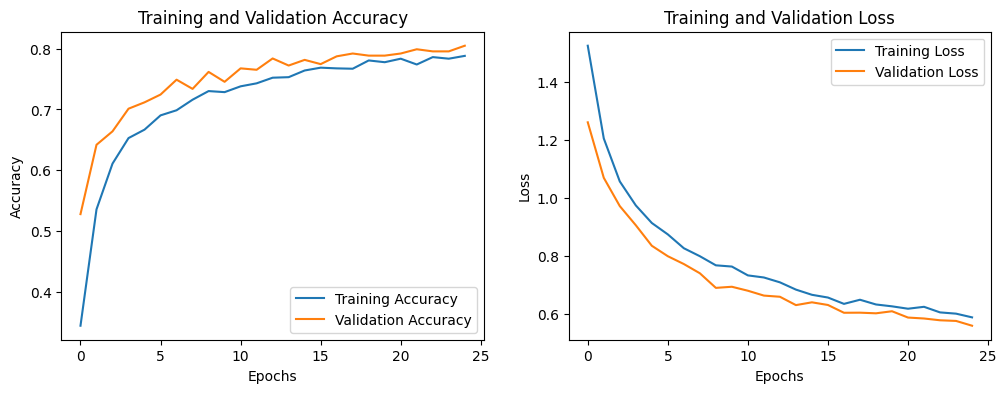

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step
Classification Report:
               precision    recall  f1-score   support

       daisy       0.83      0.83      0.83       152
   dandelion       0.81      0.84      0.82       210
        rose       0.78      0.82      0.80       156
   sunflower       0.79      0.72      0.75       146
       tulip       0.84      0.83      0.83       196

    accuracy                           0.81       860
   macro avg       0.81      0.81      0.81       860
weighted avg       0.81      0.81      0.81       860

Precision: 0.8107, Recall: 0.8105, F1 Score: 0.8101


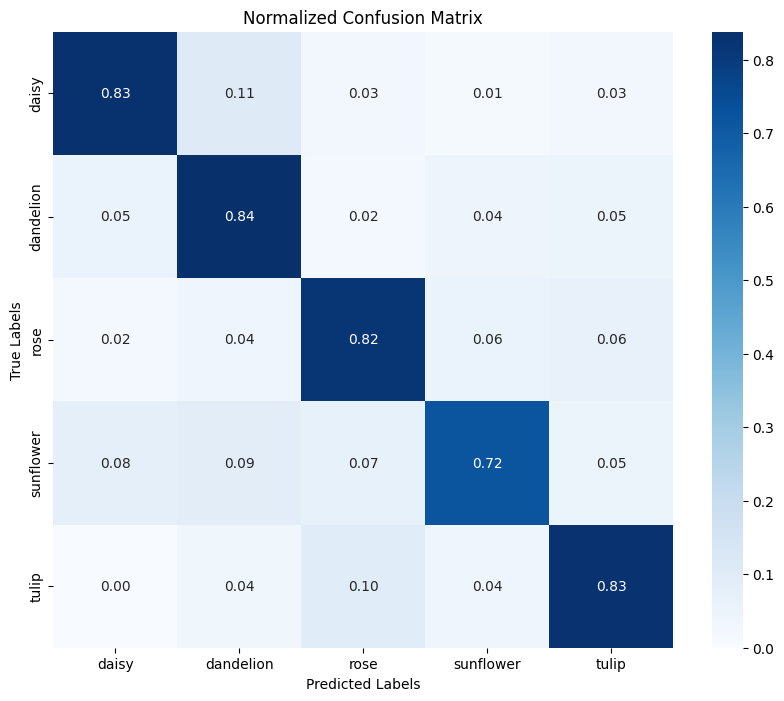

In [19]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = vgg16_model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


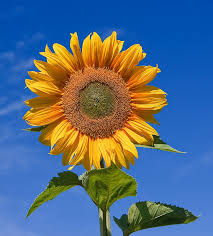

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [21]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = vgg16_model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = class_names  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))
